# Machine Temperature System Failure



In [1]:
#Dependencies
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

The Numenta Anomaly Benchmark ([NAB](https://github.com/numenta/NAB)) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, real-time applications. The *machine_temperature_system_failure.csv* dataset is based on the temperature sensor data of an internal component of a large, industrial machine. The first anomaly is a planned shutdown of the machine. The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.


In [3]:
df = pd.read_csv('machine_temperature_system_failure.csv')
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


## Data exploration

In [2]:
df.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
timestamp    22695 non-null object
value        22695 non-null float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


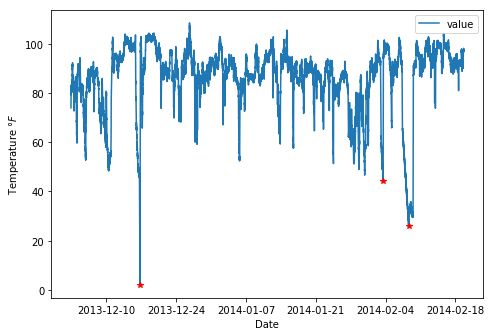

In [95]:
df['timestamp'] = pd.to_datetime(df['timestamp']) #Change to timestamp for plotting.
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(df['timestamp'],df['value'])
axes.legend(loc=0)
axes.set_xlabel('Date')
axes.set_ylabel("Temperature $°F$")
axes.plot("2013-12-16 17:25:00", 2.084721, 'r*') #Shutdown
axes.plot("2014-02-08 14:30:00", 25.887752, 'r*') #Anomaly
axes.plot("2014-02-03 11:45", 44.214951, 'r*') #Fault

plt.show()

The ﬁgure shows real-world temperature sensor data from an internal component of a large industrial machine. The ﬁrst anomaly was a planned shutdown. The third anomaly was a catastrophic system failure. The second anomaly, a subtle but observable change in the behavior, indicated the actual onset of the problem that led to the eventual system failure. 


## Feature Extraction

From the previous figure we can notice that there are some temporal and spatial anomalies.  Detecting temporal anomalies in practical applications is valuable as they can serve as an early warning for problems with the underlying system. Moreover, we extract features that we think could help with our model prediction.  Choosing informative, discriminating and independent features is a crucial step for the effectiveness of our algorithms.

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hours'] = df['timestamp'].dt.hour
df['minutes'] = df['timestamp'].dt.minute
df['month'] = df['timestamp'].dt.month
df['quarter'] = df['timestamp'].dt.quarter
df['workingHour'] = ((df['hours'] >= 6) & (df['hours'] <= 19)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
X = df.drop(['timestamp', 'time_epoch'], 1) #Numeric values only
df.head()

,timestamp,value,hours,minutes,month,quarter,workingHour,DayOfTheWeek,WeekDay,time_epoch
0,2013-12-02 21:15:00,73.967322,21,15,12,4,0,0,1,13860189
1,2013-12-02 21:20:00,74.935882,21,20,12,4,0,0,1,13860192
2,2013-12-02 21:25:00,76.124162,21,25,12,4,0,0,1,13860195
3,2013-12-02 21:30:00,78.140707,21,30,12,4,0,0,1,13860198
4,2013-12-02 21:35:00,79.329836,21,35,12,4,0,0,1,13860201


# Challenge 1: *Time Series ML Anomaly Detection*

## Isolation Forest

The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions.

In [10]:
#Model fitting
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination =0.01)
clf.fit(X)
X_outliers = clf.predict(X)

In [11]:
#Dataframe of anomalous points
anom_df=pd.Series(X_outliers).map( {1: 0, -1: 1} )
print("There are: {} anomalies.".format(sum(anom_df==1)))

There are: 227 anomalies.


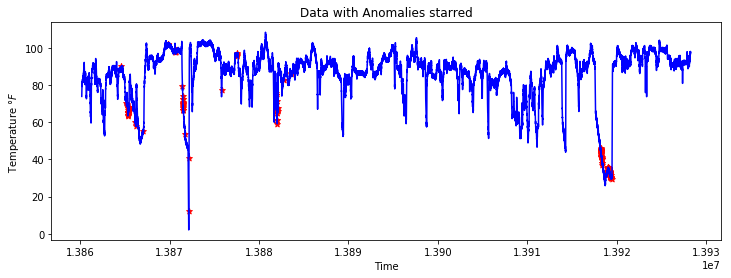

In [18]:
#Data visualisation.
fig, ax = plt.subplots(figsize=(12,4))
a = df.loc[anom_df==1, ['time_epoch', 'value']] #anomaly
ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red', marker= "*")
ax.set_title('Data with Anomalies starred')
ax.set_ylabel("Temperature $°F$")
ax.set_xlabel("Time")
plt.show()

## One Class SVM

In General, for any SVM, learning to classify means having algorithm that draws hyperplane in the feature space that separates instances into different categories. For a one-class SVM, the support vector model is trained on data that has only one class, which is the “normal” class. It takes the properties of normal cases and from these properties can predict which examples are unlike the normal examples. This is useful for anomaly detection because having insufficient training examples is what defines anomalies: that is, typically there are very few examples of the anomalous behavior.


In [19]:
#SVM need feature scaling - Data normalisation
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

In [20]:
from sklearn import svm
svm_model =  svm.OneClassSVM(nu=0.01, gamma=0.001)
svm_model.fit(X_scaled)
X_outliers = svm_model.predict(X_scaled)

In [21]:
anom_df=pd.Series(X_outliers).map( {1: 0, -1: 1} )
print("There are: {} anomalies.".format(sum(anom_df==1)))

There are: 229 anomalies.


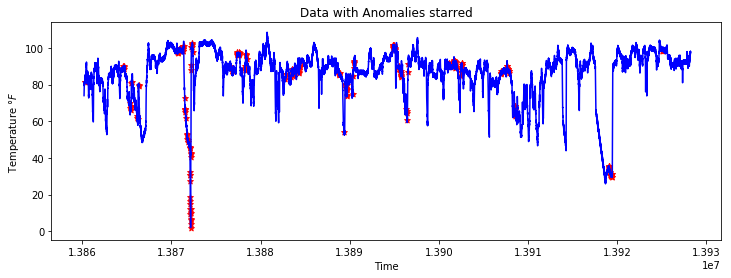

In [23]:
#Data visualisation.
fig, ax = plt.subplots(figsize=(12,4))
a = df.loc[anom_df==1, ['time_epoch', 'value']] #anomaly
ax.set_title('Data with Anomalies starred')
ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red', marker ='*')
ax.set_title('Data with Anomalies starred')
ax.set_ylabel("Temperature $°F$")
ax.set_xlabel("Time")
plt.show()

# Challenge 2: *Time Series Stats Based Anomaly Detection*

The *anom_detect* method computes the moving average based on a certain window size. This moving average method implements a simple low pass filter, moving this average is equivalent to a discrete linear convolution. Anomalous Points can then be found based on a defined significance level using an Extreme Studentized deviate (ESD) test. The intuition  behind is that it removes high frequency components by smoothing out our data.


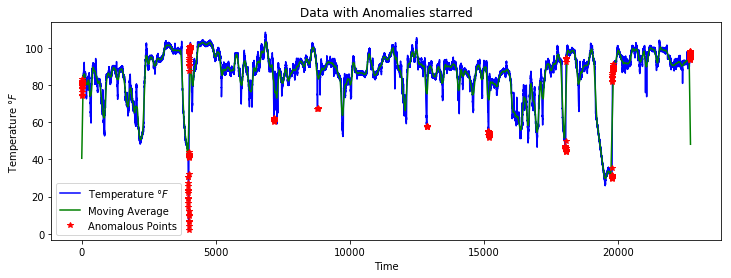

In [22]:
from anom_detect import anom_detect
an = anom_detect(window = 100, max_outliers = 200)
moving_avg = an.evaluate(df['value'])
an.plot(data_label="Temperature $°F$") #Data visualisation.

# Combining Challenge 1 & 2

We can combine the two methodologies to have a better overall result and use Moving Average as Feature Engineering for our unsupervised learning model. Before applying average moving we make the assumption that our time series is stationary, or does not show obvious trends.


In [58]:
window_size = 5000

df_values = df['value']
means = Series.rolling(df_values, center=True, window=window_size).mean()
dataframe = pd.concat([means, X], axis=1) #Adding the new feature with our previous data.
dataframe.columns = ['mean','value','hours','minutes','month','quarter','workingHour','DayOfTheWeek','WeekDay']

In [59]:
#Data cleaning
X_mean =dataframe.dropna()
X_mean =X_mean.reset_index(drop=True)

In [60]:
#ML model to train
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_mean)
svm_model =  svm.OneClassSVM(nu=0.01, gamma=0.01)
svm_model.fit(X_scaled)
X_outliers = svm_model.predict(X_scaled)

In [61]:
anom_df=pd.Series(X_outliers).map( {1: 0, -1: 1} )
print("There are: {} anomalies.".format(sum(anom_df == 1)))

There are: 178 anomalies.


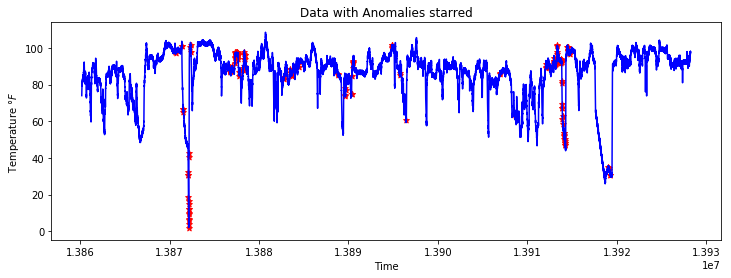

In [77]:
#Data visualisation.
new_dataframe = pd.concat([means, df[['time_epoch', 'value']]], axis=1)
new_dataframe.columns = ['mean','time_epoch','value']
new_dataframe.dropna(inplace=True) #Data cleaning
new_dataframe.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(12,4))
a = new_dataframe.loc[anom_df==1, ['time_epoch', 'value']] #anomaly
ax.set_title('Data with Anomalies starred')
ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red', marker ='*')
ax.set_title('Data with Anomalies starred')
ax.set_ylabel("Temperature $°F$")
ax.set_xlabel("Time")
plt.show()

# Results

### Performance Evaluation

Considering that we are trying to solve an unsupervised learning problem there is not an exact way to measure its performance since our data is unlabeled. Based on the information we had about the dataset we can only have an idea on how the prediction would look like.

For the cases where we cannot split the data (i.e. training and test set) it is still possible to do anomaly detection using unsupervised learning and semi-supervised learning. However, after building the model, we will have no idea how well it is doing as we have nothing to test set it against. Hence, the results of those methods need to be tested in the field before placing them in the critical system.

Since our data is unlabeled and autocorrelated we cannot treat this problem as a binary classifier, therefore we cannot get the accuracy of our model because we do not know which datapoints are correct. The only way we knew about these anomalies was because they were marked by a domain expert. Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset. On the other hand, if our data were labeled, there will be a class imbalance but it can be solved by using an ensemble built by resampling data many times, this approach has worked well and produced very good results.


### Comparison

#### Isolating Forest

The Isolation Forest algorithm shows strong promise, it did a really good work trying to minimize the noise and focusing only on the real anomalies. From the figure we can notice that most of the anomalies lay over the shutdown and the failure of the machine, albeit it could not distinguish the anomaly before the catastrophic fault. This approach is one of those good out of the box algorithms that requires less regularization in comparison with One-Class SVM. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures.


#### One-Class SVM

Strictly-speaking, the One-class SVM is not an outlier-detection method but without any assumptions on the distribution of the inlying data a One-class SVM gives useful results in these situations. Our first implementation showed a very noisy prediction, especially  between the two major anomalies. This was later corrected with the introduction of an extra feature derived from the moving average method. In the last figure we notice how it successfully identified the temporal anomaly  before reaching the catastrophic failure.

#### Moving Average Using Discrete Linear Convolution

The MA algorithm also did a good work identifying anomalous points. The use of a moving average is a simplistic approach and masks any continuous underlying trends such time dependent trends where STL methods may be more appropriate. Our model seems to detect data points that are at least 2 sigma away from the fitted curve (green line). In comparison with the two ML approaches, this is a good option when there are not a lot of features to train our ML algorithm.


#### PRO & CONS

**Isolation Forest:**

* PRO
    * Handles noisy data.
    * Simple to implement without much calculations.
    * Can convert result to a set of easily interpretable rules.
* CONS
    * Large decision trees may be hard to understand.
    * Requires fixed-length feature vectors.
    * High classification error rate while training set is small in comparison with the number of classes.
    
    
**SVM:**

* PRO
    * Effective in high dimensional spaces.
    * Memory efficient.
* CONS
    * Poor performance in large datasets.
    * Susceptible to noise.
    
    
**Moving Avg:**

* PRO
    * Easy to understand and compute.
    * Smooth out short-term fluctuations and highlight longer-term trends.
* CONS
    * Its simplicity (e.g. 1-dimensional) and subjective flexibility.
    * The general trend can change significantly depending on the time period used.
    * Is not reliable when detecting a seasonality shifts.
     
    
    
    


Some other popular ML aproaches are:

* Hidden Markov Models
* Dynamic Time Warping
* Recurrent Neural Networks
* Dynamic Bayes Nets
* Constructive induction of temporal features.
* Extracting prototype examples.
* Applying relational learning techniques.
* Nearest neighbour techniques


> By the *No free-lunch theorem* the only way to choose the best algorithm is by trying them out.

# Conclusion

Generally speaking, outliers come in three types: point anomalies, contextual anomalies and collective anomalies. SVM and Isolation Forrest are widely used for collective anomalies. They seem to be appropriate to our case because outliers seem to appear in unexpected order. At the end of the day there is no one model that works best for every problem. It is common in machine learning to try multiple models and find one that works best for a particular problem. In conclusion, we discussed how Machine Learning algorithms can be used for anomaly detection. Finally, we showed that the combination of different detection techniques can be used to improve the model performance.

